In [2]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import json
from ROOT import TLorentzVector
from optparse import OptionParser, make_option
from  pprint import pprint
import commands
import time
import datetime
start_time = time.time()

Welcome to ROOTaaS 6.06/02


In [3]:
filedir = '/work/nchernya/HHbbgg_ETH_devel/outfiles/20190321_2017_2016_for_optimization/'
filename = 'Total_preselection_diffNaming_2016_2017_21_03_2019_transformedMVA.root'

sig_names = ['reducedTree_sig','reducedTree_sig_2017']
bkg_names = ['reducedTree_bkg_0','reducedTree_bkg_1','reducedTree_bkg_2','reducedTree_bkg_0_2017']
signal_list = []
bkg_list = []
lumi_ratio = 41.5/35.9

for sig in sig_names:
    df = rpd.read_root(filedir+filename,sig, columns = ['MX',"Mjj","event","weight",'overlapSave','MVAOutputTransformed']).query('weight>=0.')
    if '2017' in sig:
        df['weight']*=lumi_ratio
    signal_list.append(df)
for bkg in bkg_names:
    df = rpd.read_root(filedir+filename,bkg, columns = ['MX',"Mjj","event","weight",'overlapSave','MVAOutputTransformed']).query('weight>=0.')
    if '2017' in bkg:
        df['weight']*=lumi_ratio 
    df['weight'] = df['weight']*df['overlapSave']
    bkg_list.append(df)    

sig = pd.concat(signal_list, axis=0, ignore_index=True)
bkg = pd.concat(bkg_list, axis=0, ignore_index=True)

In [4]:
outstr = "29_05_2019_classificationraw"
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

In [5]:
def get_total_test_sample_event_num(x_sig,x_bkg,event_sig,event_bkg,sig_frac=2,bkg_frac=5):
    x_s = x_sig[np.where(event_sig%sig_frac==0)]
    x_b = x_bkg[np.where(event_bkg%bkg_frac==0)]
    return np.concatenate((x_s,x_b))

def get_total_training_sample_event_num(x_sig,x_bkg,event_sig,event_bkg,sig_frac=2,bkg_frac=5):
    x_s = x_sig[np.where(event_sig%sig_frac!=0)]
    x_b = x_bkg[np.where(event_bkg%bkg_frac!=0)]
    return np.concatenate((x_s,x_b))

In [6]:
branch_names = 'MX,MVAOutputTransformed'.split(",") 
event_branches = ['event','weight','overlapSave']
branch_names = [c.strip() for c in branch_names]

X_sig =  np.asarray(sig[branch_names])
w_sig =  np.asarray(sig['weight'])
w_sig = w_sig/w_sig.sum()
event_sig =  np.asarray(sig['event'])
y_sig =  np.asarray((np.ones_like(sig.index)*1).astype(np.int8))

X_bkg =  np.asarray(bkg[branch_names])
w_bkg =  np.asarray(bkg['weight'])
w_bkg = w_bkg/w_bkg.sum()
event_bkg =  np.asarray(bkg['event'])
y_bkg =  np.asarray((np.ones_like(bkg.index)*-1).astype(np.int8))

#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig,y_bkg,event_sig,event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig,event_bkg)

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig,y_bkg,event_sig,event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig,event_bkg)

w_total_train = preprocessing.get_total_training_sample_event_num(w_sig,w_bkg,event_sig,event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(w_sig,w_bkg,event_sig,event_bkg).ravel()


In [194]:
print "Starting the training now : "
now = str(datetime.datetime.now())
print(now)

################Training a classifier###############
########final optimization with all fixed#######
from sklearn.externals import joblib
import xgboost as xgb
n_threads=20

#clf = xgb.XGBClassifier(objective='binary:logitraw',nthread=n_threads,n_estimators=300)

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
   colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
   max_depth=7, min_child_weight=0.0001, 
   n_estimators=200, n_jobs=1, nthread=n_threads, objective='binary:logitraw',
   random_state=0, reg_alpha=0.0, reg_lambda=0.05, scale_pos_weight=1,
   seed=0, silent=True, subsample=1)

clf.fit(X_total_train,y_total_train, sample_weight=w_total_train,verbose=True)


print 'Training is done. It took', time.time()-start_time, 'seconds.'

joblib.dump(clf, os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_%s.pkl'%outstr), compress=9)


Starting the training now : 
2019-05-29 14:06:41.375229
Training is done. It took 995.150449038 seconds.


['/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_29_05_2019_classificationraw.pkl']

In [8]:
training = '/work/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_29_05_2019_classificationraw.pkl'
from sklearn.externals import joblib
import xgboost as xgb
n_threads=20
clf = joblib.load(training)
Y_pred_sig = clf.predict_proba(X_total_train[y_total_train > 0])[:,clf.n_classes_-1]
Y_pred_bkg = clf.predict_proba(X_total_train[y_total_train < 0])[:,clf.n_classes_-1]

In [90]:
Y_pred_test_sig = clf.predict_proba(X_total_test[y_total_test > 0])[:,clf.n_classes_-1]
Y_pred_test_bkg = clf.predict_proba(X_total_test[y_total_test < 0])[:,clf.n_classes_-1]

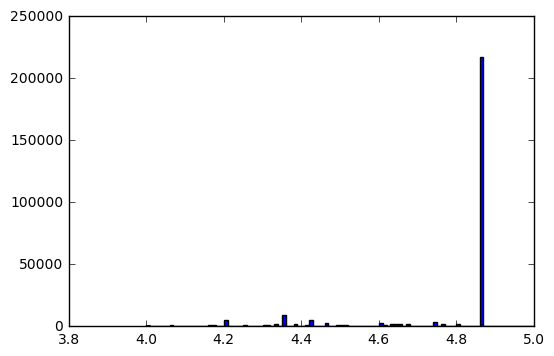

In [93]:
plt.hist(Y_pred_test_sig,bins=100,range=[4,5.])
plt.show()
#plt.hist(Y_pred_bkg,bins=50)
#plt.show()
#plt.hist(X_total_train[y_total_train > 0][Y_pred_sig>4.862871][:,1],bins=100)
#plt.show()
#plt.hist(X_total_train[y_total_train < 0][Y_pred_bkg>4.862871][:,1],bins=100)
#plt.show()
#plt.hist(X_total_train[y_total_train > 0][Y_pred_sig>4.862871][:,0],bins=100)
#plt.show()
#plt.hist(X_total_train[y_total_train < 0][Y_pred_bkg>4.862871][:,0],bins=100)
#plt.show()

In [97]:
print len(Y_pred_test_sig), len(Y_pred_sig)
print len(Y_pred_test_bkg), len(Y_pred_bkg)

566159 565722
671480 2686340


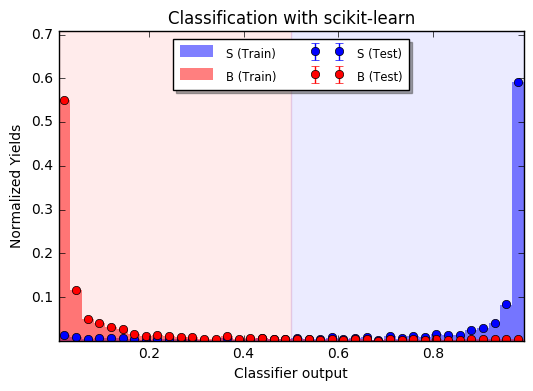

In [130]:
plot_classifier = plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString=outstr)
plt.show()

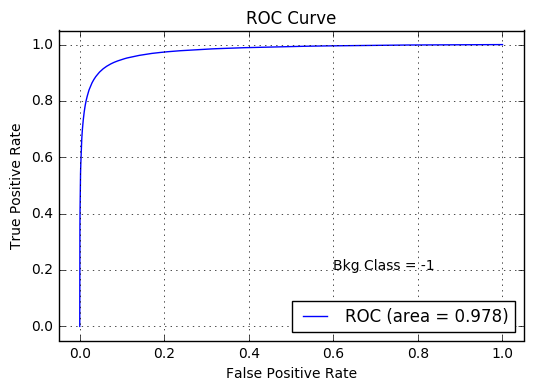

In [131]:
fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
plt.show()

## Categorization by MX times MVA

In [102]:
categories_MX = [250,336, 411 ,556]
categories_MVA = [ 0.230 , 0.455, 0.709]

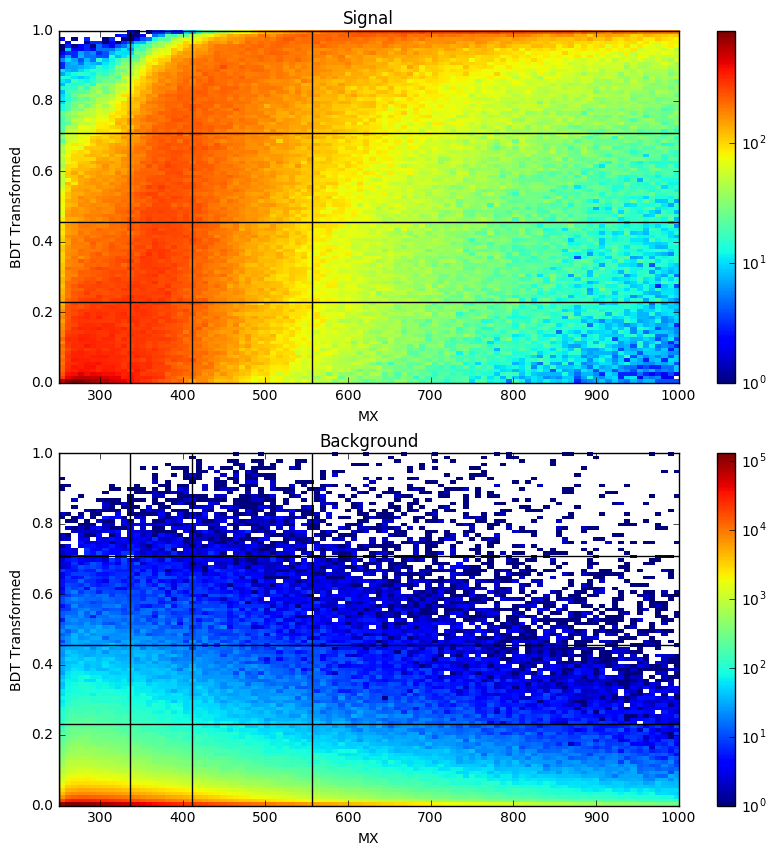

In [103]:
plt.clf()
from matplotlib.colors import LogNorm
plt.figure(figsize=(10,10))

plt.subplot(2,1, 1)
plt.title('Signal')
plt.xlabel('MX')
plt.ylabel('BDT Transformed')
img_sig = plt.hist2d(sig['MX'],sig['MVAOutputTransformed'], bins=(100,100),range=[[250,1000],[0,1]],norm=LogNorm())
plt.colorbar()
for mx in categories_MX:
    x = np.linspace(mx,mx)
    plt.plot(x, np.linspace(0,1), color="k")
for mva in categories_MVA:
    x = np.linspace(mva,mva)
    plt.plot(np.linspace(250,1000),x, color="k")    


plt.subplot(2,1, 2)
plt.title('Background')
img_bkg = plt.hist2d(bkg['MX'],bkg['MVAOutputTransformed'], bins=(100,100),range=[[250,1000],[0,1]],norm=LogNorm())
plt.xlabel('MX')
plt.ylabel('BDT Transformed')
plt.colorbar()
for mx in categories_MX:
    x = np.linspace(mx,mx)
    plt.plot(x, np.linspace(0,1), color="k")
for mva in categories_MVA:
    x = np.linspace(mva,mva)
    plt.plot(np.linspace(250,1000),x, color="k") 

plt.subplots_adjust(wspace=0.5, hspace=.2)
plt.show()

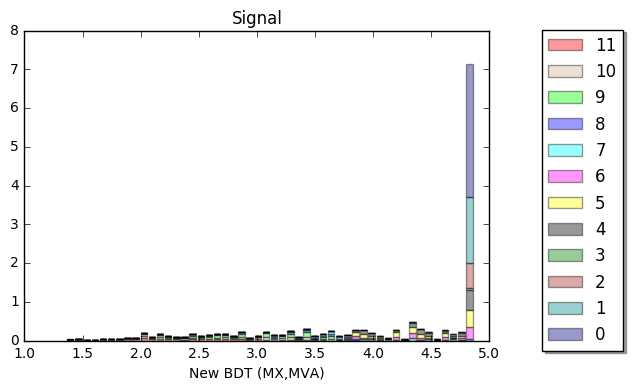

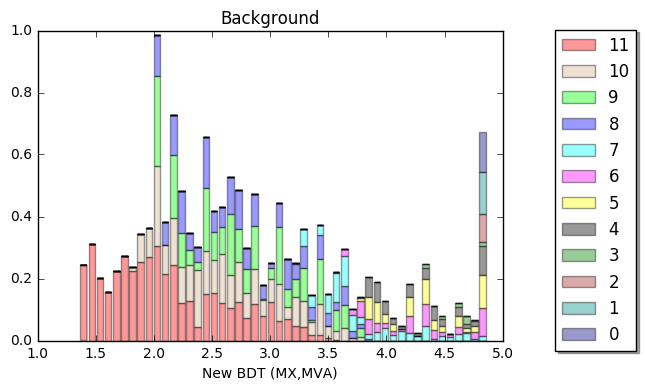

In [98]:
categories_MX = [250,336, 411 ,556,4000]
categories_MVA =[0.230 , 0.455, 0.709,1.0]

plt.clf()
signal_values = []
bkg_values = []
for mva_num in range(0,len(categories_MVA)-1):
    for mx_num in range(0,len(categories_MX)-1):
        signal_values.append(Y_pred_test_sig[(X_total_test[y_total_test>0][:,1]>categories_MVA[mva_num])&
                            (X_total_test[y_total_test>0][:,1]<=categories_MVA[mva_num+1]) &
                            (X_total_test[y_total_test>0][:,0]>categories_MX[mx_num]) &
                            (X_total_test[y_total_test>0][:,0]<=categories_MX[mx_num+1]) ])
        bkg_values.append(Y_pred_test_bkg[(X_total_test[y_total_test<0][:,1]>categories_MVA[mva_num])&
                            (X_total_test[y_total_test<0][:,1]<=categories_MVA[mva_num+1]) &
                            (X_total_test[y_total_test<0][:,0]>categories_MX[mx_num]) &
                            (X_total_test[y_total_test<0][:,0]<=categories_MX[mx_num+1]) ])
        

colors = ['red', 'tan', 'lime','blue','cyan','magenta','yellow','black','green','brown','darkcyan','navy']
categories = sorted(np.arange(0,12,1),reverse=True)

#plt.yscale('log')
plt.title('Signal')
plt.xlabel('New BDT (MX,MVA)')
plt.hist(signal_values,bins=50,
                 histtype='bar', normed=1,stacked=True,alpha=0.4,color=colors,label=categories)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.03), shadow=True, ncol=1)
plt.show()

#plt.yscale('log')
plt.title('Background')
plt.xlabel('New BDT (MX,MVA)')
plt.legend(loc='upper left')
plt.hist(bkg_values,bins=50,
                 histtype='bar',normed=1, stacked=True,alpha=0.4,color=colors,label=categories)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.03), shadow=True, ncol=1)
plt.show()

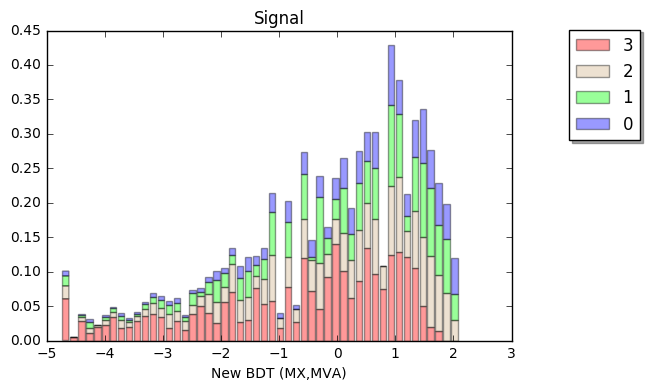

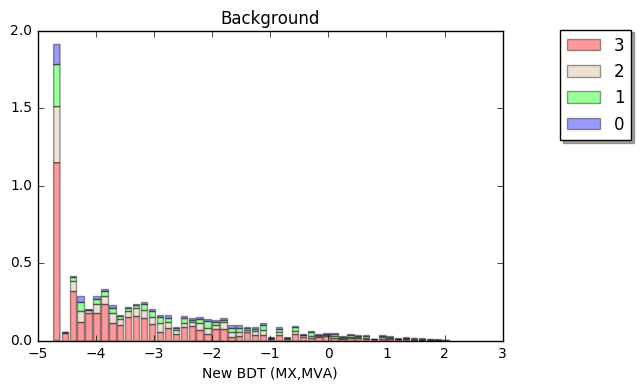

In [99]:
categories_MX = [250,336, 411 ,556,4000]
categories_MVA =[0,0.230 ]

plt.clf()
signal_values = []
bkg_values = []
for mx_num in range(0,len(categories_MX)-1):
    for mva_num in range(0,len(categories_MVA)-1):
        signal_values.append(Y_pred_test_sig[(X_total_test[y_total_test>0][:,1]>categories_MVA[mva_num])&
                            (X_total_test[y_total_test>0][:,1]<=categories_MVA[mva_num+1]) &
                            (X_total_test[y_total_test>0][:,0]>categories_MX[mx_num]) &
                            (X_total_test[y_total_test>0][:,0]<=categories_MX[mx_num+1]) ])
        bkg_values.append(Y_pred_test_bkg[(X_total_test[y_total_test<0][:,1]>categories_MVA[mva_num])&
                            (X_total_test[y_total_test<0][:,1]<=categories_MVA[mva_num+1]) &
                            (X_total_test[y_total_test<0][:,0]>categories_MX[mx_num]) &
                            (X_total_test[y_total_test<0][:,0]<=categories_MX[mx_num+1]) ])

        


colors = ['red', 'tan', 'lime','blue']
categories = sorted(np.arange(0,4,1),reverse=True)

#plt.yscale('log')
plt.title('Signal')
plt.xlabel('New BDT (MX,MVA)')
plt.hist(signal_values,bins=50,
                 histtype='bar', normed=1,stacked=True,alpha=0.4,color=colors,label=categories)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.03), shadow=True, ncol=1)
plt.show()

#plt.yscale('log')
plt.title('Background')
plt.xlabel('New BDT (MX,MVA)')
plt.legend(loc='upper left')
plt.hist(bkg_values,bins=50,
                 histtype='bar',normed=1, stacked=True,alpha=0.4,color=colors,label=categories)
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1.03), shadow=True, ncol=1)
plt.show()